In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
df = pd.read_csv('final.csv')
# df=df.drop('Unnamed: 0',axis=1)
df.head()

,index,Open,High,Low,Close,Volume,CionScore,Coin_timestamp,UpDown
0,0,387.427002,391.378998,380.779999,383.614990,26229400.0,-0.224409,1.412093e+09,1
1,1,383.988007,385.497009,372.946014,375.071991,21777700.0,0.162439,1.412179e+09,0
2,2,375.181000,377.695007,357.859009,359.511993,30901200.0,-0.136249,1.412266e+09,0
3,3,359.891998,364.487000,325.885986,328.865997,47236500.0,-0.136249,1.412352e+09,0
4,4,328.915985,341.800995,289.295990,320.510010,83308096.0,-0.136249,1.412438e+09,0


In [4]:
target = df['UpDown']
exog = df[['Open', 'High', 'Low', 'Close', 'Volume','CionScore','Coin_timestamp']]

In [5]:
ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -58.241008545332626
p-value: 0.0


In [6]:
target_diff = target.diff()

ad_fuller_result = adfuller(target_diff[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -17.236890048192176
p-value: 6.142258167945864e-30


In [7]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [10]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 7

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [11]:
target_train = target[:200]
exog_train = exog[:200]

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(1, 2, 0, 0)",196.420833
1,"(0, 2, 0, 0)",197.007025
2,"(1, 2, 1, 0)",198.829974
3,"(0, 2, 0, 2)",199.495770
4,"(3, 2, 0, 0)",199.597125
...,...,...
251,"(2, 1, 0, 0)",473.602992
252,"(2, 1, 1, 0)",474.800351
253,"(2, 1, 0, 1)",475.868036
254,"(2, 1, 1, 1)",477.425441


In [12]:
best_model = SARIMAX(target_train, exog_train, order=(1,0,2), seasonal_order=(0,0,0,7), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 UpDown   No. Observations:                  200
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 -71.633
Date:                Wed, 12 Apr 2023   AIC                            165.265
Time:                        09:58:52   BIC                            201.547
Sample:                             0   HQIC                           179.948
                                - 200                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Open              -0.0287   7.12e-05   -403.606      0.000      -0.029      -0.029
High              -0.0072   7.63e-05    -94.392      0.000      -0.007      -0.007
Low                0.0032   7.08e-05

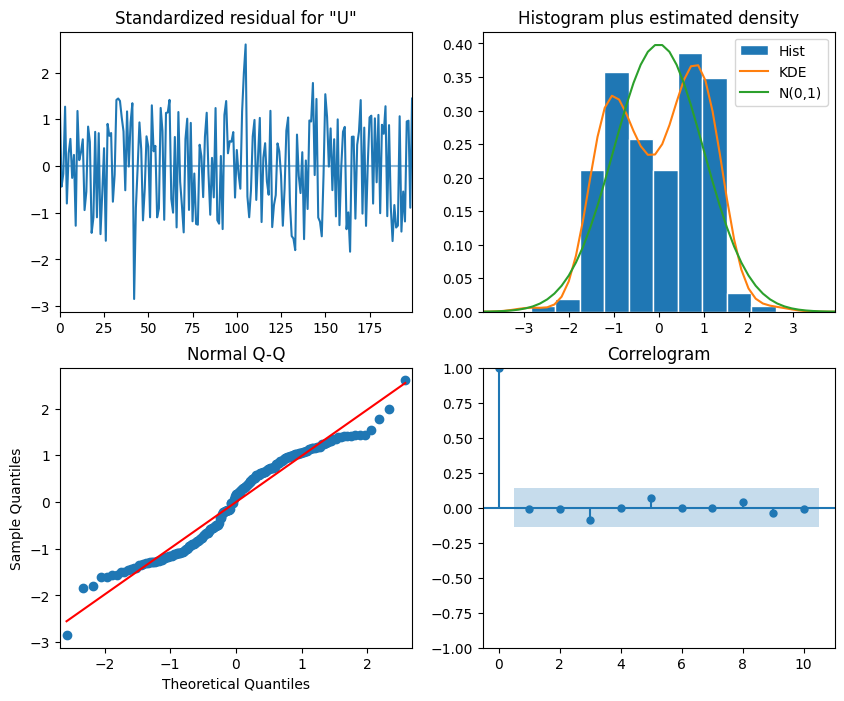

In [13]:
best_model_fit.plot_diagnostics(figsize=(10,8));

plt.savefig('figures/CH09_F05_peixeiro.png', dpi=300)

In [14]:
residuals = best_model_fit.resid

pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

pvalue['lb_pvalue']

1     0.891026
2     0.976196
3     0.653500
4     0.803569
5     0.762990
6     0.857781
7     0.919498
8     0.937694
9     0.953493
10    0.974039
Name: lb_pvalue, dtype: float64

In [15]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [16]:
target_train = target[:196]
target_test = target[196:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

KeyboardInterrupt: 

In [24]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [25]:
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

0.736849498653785 0.7029758584959033


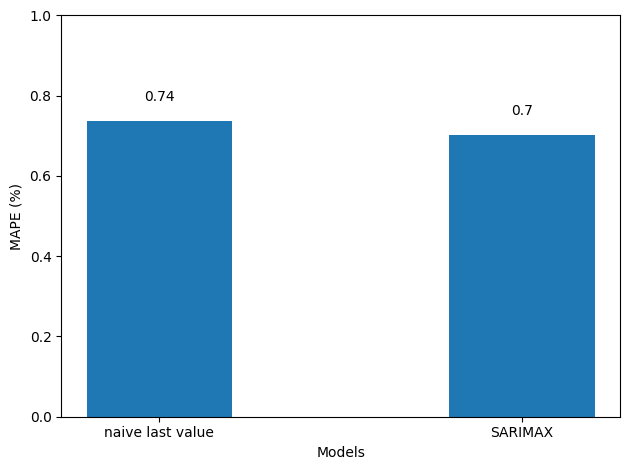

In [26]:
fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH09_F06_peixeiro.png', dpi=300)